In [244]:
print('hello')

hello


In [245]:
import torch
print(torch.cuda.is_available())

True


In [6]:
from torchvision import datasets, transforms

In [7]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [225]:
home = '/home/icb/fatemehs.hashemig'
data_path = f'{home}/data'
train = datasets.MNIST(data_path, train=True,
                   transform=transform)
test = datasets.MNIST(data_path, train=False,
                   transform=transform)

In [226]:
batch_size = 256
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}

use_cuda = torch.cuda.is_available()
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [227]:
train_loader = torch.utils.data.DataLoader(train,**train_kwargs)
test_loader = torch.utils.data.DataLoader(test, **test_kwargs)

In [228]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [229]:
img, label = train[0]

In [230]:
img.shape, label

(torch.Size([1, 28, 28]), 5)

In [232]:
image.squeeze().shape

torch.Size([28, 28])

Image shape: torch.Size([1, 28, 28])


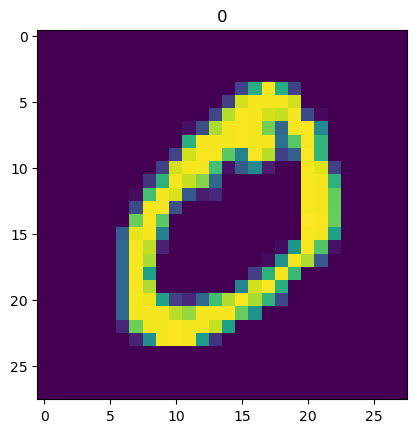

In [231]:
import matplotlib.pyplot as plt
image, label = train[1]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

In [17]:
from autoencoder import vae_loss, VariationalAutoencoder

In [102]:
import torch
import torch.nn as nn
import wandb


class ProtClassifier(VariationalAutoencoder):
    def __init__(self, num_prototypes, num_classes, **kwds) -> None:

        self.num_prototypes = num_prototypes
        self.num_classes = num_classes

        super().__init__(**kwds)
        self.prototype_shape = (self.num_prototypes, self.latent_dims)
        self.prototype_vectors = nn.Parameter(
            torch.rand(self.prototype_shape), requires_grad=True
        )
        self.classifier = nn.Linear(
            self.num_prototypes, self.num_classes, bias=False
        )  # do not use bias
        self.interpretablity_regularization_loss = 0
        self.reg1 = 0.05
        self.reg2 = 0.05
        self.vae_reg = 0.5
        self.classification_loss = nn.CrossEntropyLoss()

    def prototype_distance(self, z: torch.Tensor):
        return torch.cdist(z, self.prototype_vectors)

    def feature_vector_distance(self, z: torch.Tensor):
        return torch.cdist(self.prototype_vectors, z)

    def forward(self, x):

        z = self.encoder(x)

        p_dist = self.prototype_distance(z)
        f_dist = self.feature_vector_distance(z)
        self.interpretablity_regularization_loss = self.reg1 * p_dist.min(
            1
        ).values.mean() + self.reg2 * f_dist.min(1).values.mean()

        p_dist = p_dist.reshape(-1, self.num_prototypes)
        logits = self.classifier(p_dist)
        return self.decoder(z), logits


def calculate_loss(x, x_hat, y, y_pred, model: ProtClassifier):
    vae = vae_loss(x, x_hat, model.encoder.kl)
    classification = model.classification_loss(y_pred, y)
    loss = (
        model.interpretablity_regularization_loss + model.vae_reg * vae + classification
    )

    return loss, vae, classification


def train_step(model: ProtClassifier, data_loader, optimizer, device):
    model.to(device)
    overal_loss, overal_vae, overal_classification, ovarl_interpretablity = 0, 0, 0, 0
    for x, y in data_loader:
        # 1. Forward pass
        x_hat, logits = model(x)

        # 2. Calculate loss
        loss, vae, classification = calculate_loss(x, x_hat, y, logits, model)
        overal_loss += loss
        overal_vae += vae
        overal_classification += classification
        ovarl_interpretablity += model.interpretablity_regularization_loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    overal_loss /= len(data_loader)
    return overal_loss


def test_step(data_loader, model, device):

    overal_loss, overal_vae, overal_classification, ovarl_interpretablity = 0, 0, 0, 0
    acc = 0
    model.to(device)
    model.eval()  # put model in eval mode

    # Turn on inference context manager
    with torch.inference_mode():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            h, w = x.shape[2:]
            x = x.reshape(-1, h*w)
            
            # 1. Forward pass
            x_hat, y_pred = model(x)

            # 2. Calculate loss
            loss, vae, classification = calculate_loss(x, x_hat, y, y_pred, model)
            overal_loss += loss
            overal_vae += vae
            overal_classification += classification
            ovarl_interpretablity += model.interpretablity_regularization_loss

            # 2. Calculate loss and accuracy
            # Calculate and accumulate accuracy
            pred_labels = y_pred.argmax(dim=1)
            acc += ((pred_labels == y).sum().item()/len(y))

    return (
        overal_loss / len(data_loader),
        overal_vae / len(data_loader),
        overal_classification / len(data_loader),
        ovarl_interpretablity / len(data_loader),
        acc/len(data_loader)
    )


In [103]:
num_prototypes, num_classes = 10, 10
input_dim, hidden_dim, latent_dims = 28*28, 64, 32
model = ProtClassifier(num_prototypes=num_prototypes, num_classes=num_classes,
                      input_dim=input_dim, hidden_dim=hidden_dim, latent_dims=latent_dims)

32


In [104]:
x, y = next(iter(train_loader))

In [105]:
device = "cuda" if torch.cuda.is_available() else "cpu"
x = x.to(device)
model.to(device)

ProtClassifier(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=64, bias=True)
    (linear2): Linear(in_features=64, out_features=32, bias=True)
    (linear3): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=32, out_features=64, bias=True)
    (linear2): Linear(in_features=64, out_features=784, bias=True)
  )
  (classifier): Linear(in_features=10, out_features=10, bias=False)
  (classification_loss): CrossEntropyLoss()
)

In [106]:
x = x.reshape(-1, 28*28)

In [107]:
y = y.to(device)

In [108]:
test_step(test_loader, model, device)

(tensor(126799.0859, device='cuda:0'),
 tensor(253576.9844, device='cuda:0'),
 tensor(10.0109, device='cuda:0'),
 tensor(0.5680, device='cuda:0'),
 0.106640625)

In [84]:
h, w = x.shape

In [85]:
h, w

(256, 784)

In [94]:
for x, y in test_loader:
    print(x.shape[2:])
    break

torch.Size([28, 28])


In [110]:
def get_dict():
    return {1:2}



a = get_dict()
b = get_dict()
a[1]=4
print(b)

{1: 2}


In [112]:
a = {"a"}
for key in a:
    a[key]=0

TypeError: 'set' object does not support item assignment

In [143]:
class PrototypeLoss:
    def __init__(self) -> None:
        self.vae, self.classification, self.interpretablity = 0, 0, 0
        self.loss = 0

    def calculate(self, x, x_hat, y, y_pred, model: ProtClassifier):
        self.vae = vae_loss(x, x_hat, model.encoder.kl)
        self.classification = model.classification_loss(y_pred, y)
        self.loss = (
            model.interpretablity_regularization_loss
            + model.vae_reg * self.vae
            + self.classification
        )

    def __add__(self, l):
        new_loss = PrototypeLoss()
        new_loss.vae = self.vae + l.vae
        new_loss.classification = self.classification + l.classification
        new_loss.interpretablity = self.interpretablity + l.interpretablity
        new_loss.loss = self.loss + l.loss
        return new_loss

    def normalize(self, data_loader_size):
        self.vae /= data_loader_size
        self.classification /= data_loader_size
        self.interpretablity /= data_loader_size
        self.loss /= data_loader_size

In [210]:
import torch
import torch.nn as nn
import wandb
from autoencoder import vae_loss, VariationalAutoencoder, get_device


from torchvision import datasets, transforms
import torch.optim as optim
import time
from tqdm.auto import tqdm


class ProtClassifier(VariationalAutoencoder):
    def __init__(self, num_prototypes, num_classes, **kwds) -> None:

        self.num_prototypes = num_prototypes
        self.num_classes = num_classes

        super().__init__(**kwds)
        self.prototype_shape = (self.num_prototypes, self.latent_dims)
        self.prototype_vectors = nn.Parameter(
            torch.rand(self.prototype_shape), requires_grad=True
        )
        self.classifier = nn.Linear(
            self.num_prototypes, self.num_classes, bias=False
        )  # do not use bias
        self.reg1 = 0.05
        self.reg2 = 0.05
        self.vae_reg = 0.5
        self.classification_loss = nn.CrossEntropyLoss()

    def prototype_distance(self, z: torch.Tensor):
        return torch.cdist(z, self.prototype_vectors)

    def feature_vector_distance(self, z: torch.Tensor):
        return torch.cdist(self.prototype_vectors, z)

    def forward(self, x):
        z = self.encoder(x)
        p_dist = self.prototype_distance(z)
        p_dist = p_dist.reshape(-1, self.num_prototypes)
        logits = self.classifier(p_dist)
        return z, self.decoder(z), logits

    def calculate_interpretablity_loss(self, z):
        p_dist = self.prototype_distance(z)
        f_dist = self.feature_vector_distance(z)
        return (
            self.reg1 * p_dist.min(1).values.mean()
            + self.reg2 * f_dist.min(1).values.mean()
        )


class PrototypeLoss:
    def __init__(self) -> None:
        self.vae, self.classification, self.interpretablity = 0, 0, 0
        self.loss = 0

    def calculate(self, x, x_hat, z, y, y_pred, model: ProtClassifier):
        self.vae = vae_loss(x, x_hat, model.encoder.kl)
        self.classification = model.classification_loss(y_pred, y)
        self.interpretablity = model.calculate_interpretablity_loss(z)
        self.loss = (
            self.interpretablity + model.vae_reg * self.vae + self.classification
        )

    def __add__(self, l):
        new_loss = PrototypeLoss()
        new_loss.vae = self.vae + l.vae
        new_loss.classification = self.classification + l.classification
        new_loss.interpretablity = self.interpretablity + l.interpretablity
        new_loss.loss = self.loss + l.loss
        return new_loss

    def normalize(self, data_loader_size):
        self.vae /= data_loader_size
        self.classification /= data_loader_size
        self.interpretablity /= data_loader_size
        self.loss /= data_loader_size


def train_step(model: ProtClassifier, data_loader, optimizer, device):
    model.to(device)

    overal_loss = PrototypeLoss()

    for x, y in data_loader:
        # 1. Forward pass
        x, y = x.to(device), y.to(device)
        h, w = x.shape[2:]
        x = x.reshape(-1, h * w)
        z, x_hat, logits = model.forward(x)

        # 2. Calculate loss
        batch_loss = PrototypeLoss()
        batch_loss.calculate(x, x_hat, z, y, logits, model)
        overal_loss += batch_loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        batch_loss.loss.backward()

        # 5. Optimizer step
        optimizer.step()
    overal_loss.normalize(len(data_loader))
    return overal_loss.__dict__


def test_step(data_loader, model, device):

    test_loss = PrototypeLoss()
    acc = 0
    model.to(device)
    model.eval()  # put model in eval mode

    # Turn on inference context manager
    with torch.inference_mode():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            h, w = x.shape[2:]
            x = x.reshape(-1, h * w)

            # 1. Forward pass
            z, x_hat, y_pred = model(x)

            # 2. Calculate loss
            batch_loss = PrototypeLoss()
            batch_loss.calculate(x, x_hat, z, y, y_pred, model)
            test_loss += batch_loss

            # 2. Calculate loss and accuracy
            # Calculate and accumulate accuracy
            pred_labels = y_pred.argmax(dim=1)
            acc += (pred_labels == y).sum().item() / len(y)
        test_loss.normalize(len(data_loader))
    return test_loss.__dict__


def get_home():
    return "/home/icb/fatemehs.hashemig"


def load_data():
    # load data
    batch_size = 16
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    home = get_home()
    data_path = f"{home}/data"
    train = datasets.MNIST(data_path, train=True, transform=transform)
    test = datasets.MNIST(data_path, train=False, transform=transform)
    train_kwargs = {"batch_size": batch_size}
    test_kwargs = {"batch_size": batch_size}

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    train_loader = torch.utils.data.DataLoader(train, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(test, **test_kwargs)
    return train_loader, test_loader


def add_prefix_key(dict, prefix):
    new_dict = {}
    for key in dict:
        new_dict[f"{prefix}_{key}"] = dict[key]
    return new_dict



In [212]:
# init wandb
wandb.init(
    # set the wandb project where this run will be logged
    project="interpretable-ssl",
    # track hyperparameters and run metadata
    config={
        "model": "mnist-protoype-classifier",
        "num_prototypes": num_prototypes,
        "hidden dim": hidden_dim,
        "latent_dims": latent_dims,
        "epochs": epochs,
        "device": device,
        "model path": model_path,
    },
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁
test_classification,█▁▅
test_interpretablity,▁█▇
test_loss,█▇▁
test_vae,█▇▁
train_classification,█▁▅
train_interpretablity,█▆▁
train_loss,█▇▁
train_vae,█▇▁
epoch,0
test_classification,1.16807


In [213]:
device = get_device()
print(device)

# laod data
train_loader, test_loader = load_data()

# define model
num_prototypes, num_classes = 10, 10
input_dim, hidden_dim, latent_dims = 28 * 28, 64, 32
model = ProtClassifier(
    num_prototypes=num_prototypes,
    num_classes=num_classes,
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dims=latent_dims,
)
# init training parameters
epochs = 100

optimizer = optim.Adam(model.parameters(), lr=0.003)
model_path = get_home() + "/models/prototype-classifier.pth"
best_test_loss = 100000
print("start training")
st = time.time()
for epoch in tqdm(range(epochs)):
    train_loss = train_step(model, train_loader, optimizer, device)
    train_loss_dict = add_prefix_key(train_loss, 'train')
    


    if epoch%5 == 0:
        test_loss = test_step(test_loader, model, device)
        test_loss_dict = add_prefix_key(test_loss, 'test')
    
        train_loss_dict.update(test_loss_dict)
        train_loss_dict['epoch'] = epoch
        wandb.log(train_loss_dict)

print(f"training took {time.time() - st} seconds")


cuda
32
start training


100%|██████████| 100/100 [25:02<00:00, 15.03s/it]

training took 1502.7502760887146 seconds


In [214]:
for epoch in tqdm(range(epochs)):
    train_loss = train_step(model, train_loader, optimizer, device)
    train_loss_dict = add_prefix_key(train_loss, 'train')
    


    if (epoch+10)%5 == 0:
        test_loss = test_step(test_loader, model, device)
        test_loss_dict = add_prefix_key(test_loss, 'test')
    
        train_loss_dict.update(test_loss_dict)
        train_loss_dict['epoch'] = epoch + 10
        wandb.log(train_loss_dict)

100%|██████████| 100/100 [25:39<00:00, 15.39s/it]


In [217]:
p_decode = model.decoder(model.prototype_vectors)

In [220]:
p_decode = p_decode.reshape(10, 28, 28)

In [233]:
p_decode[0].shape

torch.Size([28, 28])

Image shape: (28, 28)
Image shape: (28, 28)
Image shape: (28, 28)
Image shape: (28, 28)
Image shape: (28, 28)
Image shape: (28, 28)
Image shape: (28, 28)
Image shape: (28, 28)
Image shape: (28, 28)
Image shape: (28, 28)


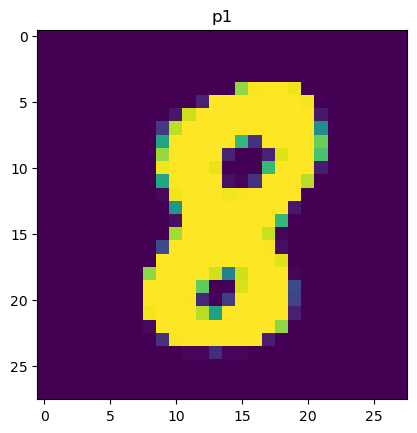

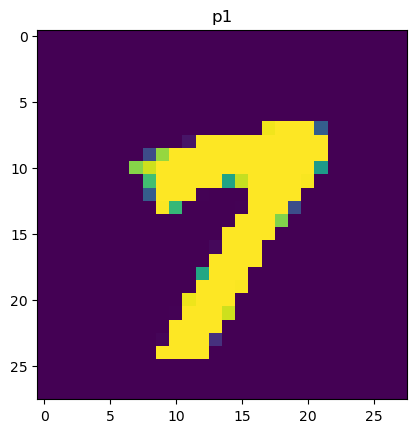

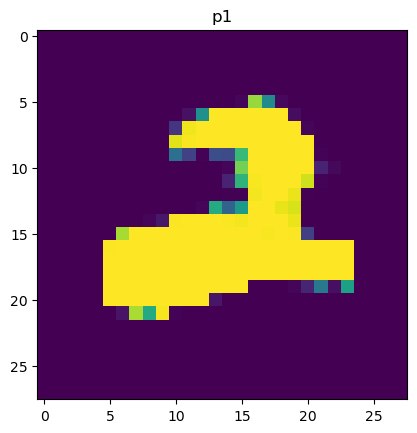

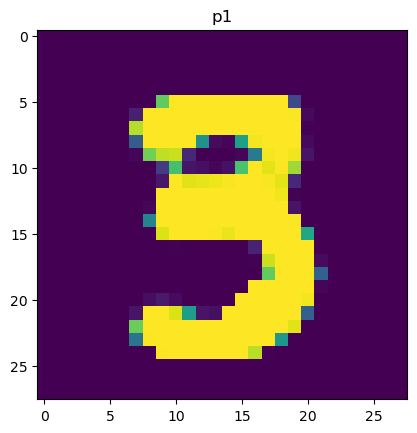

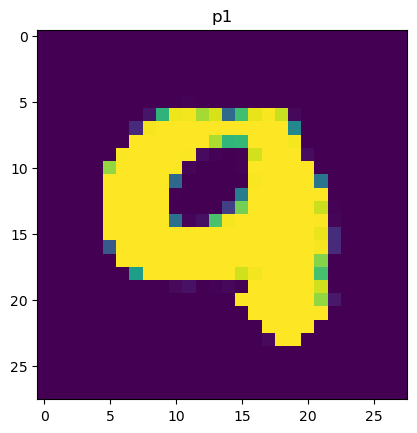

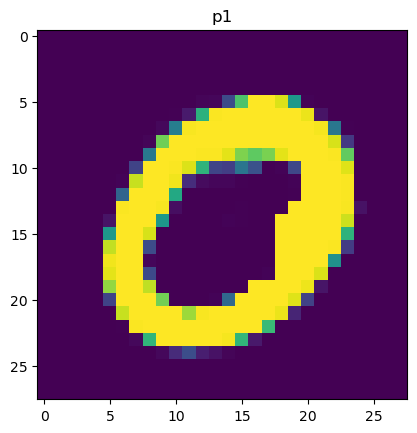

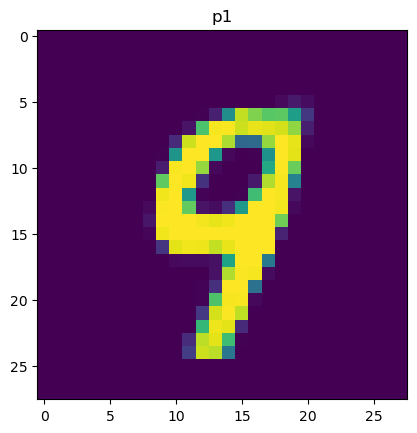

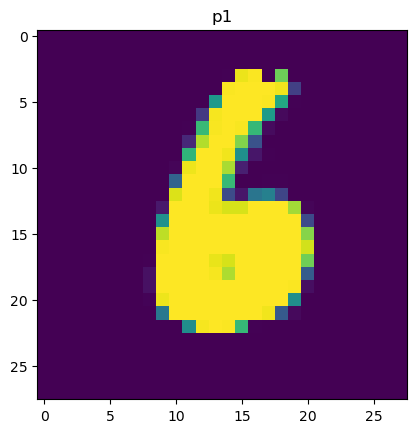

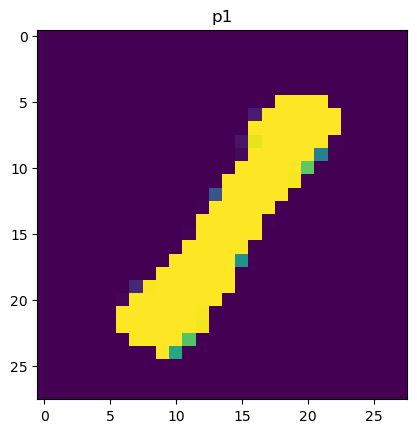

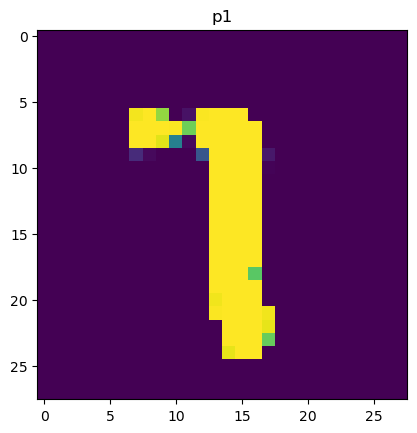

In [243]:
import matplotlib.pyplot as plt
for i in range(10):
    image, label = p_decode[i].to('cpu').detach().numpy(), 'p1'
    plt.figure()
    print(f"Image shape: {image.shape}")
    plt.imshow(image) # image shape is [1, 28, 28] (colour channels, height, width)
    plt.title(label);